# Homework \#0 (Getting started in Optimization)

Alles Rebel

Computational Science PhD

## Julia Package Requirements

In [1]:
import Pkg; 
Pkg.add("Plots")
Pkg.add("ForwardDiff")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


## **Exercise 2.1.** Adopt the forward difference method to approximate the Hessian of $f(x)$ using its gradient, $\nabla f(x)$.

To begin we'll start with Algorithm 2.1 from the book, defining the finite differences for forward, central and backwards in Julia.

In [2]:
diff_forward(f, x; h=sqrt(eps(Float64))) = (f(x+h) - f(x))/h
diff_central(f, x; h=cbrt(eps(Float64))) = (f(x+h/2) - f(x-h/2))/h
diff_backward(f, x; h=sqrt(eps(Float64))) = (f(x) - f(x-h))/h
# Algorithm 2.1 from Kochenderfer and Wheeler's Algorithms for Optimization

diff_backward (generic function with 1 method)

We'll apply these definitions to the definition of an Hessian:

$$
H(f) = \nabla^2 f(x) =
\begin{bmatrix}
    \frac{\partial^2 f}{\partial x_1^2} & \frac{\partial^2 f}{\partial x_1 \partial x_2} & \dots & \frac{\partial^2 f}{\partial x_1 \partial x_n} \\
    \frac{\partial^2 f}{\partial x_2 \partial x_1} & \frac{\partial^2 f}{\partial x_2^2} & \dots & \frac{\partial^2 f}{\partial x_2 \partial x_n} \\
    \vdots & \vdots & \ddots & \vdots \\
    \frac{\partial^2 f}{\partial x_n \partial x_1} & \frac{\partial^2 f}{\partial x_n \partial x_2} & \dots & \frac{\partial^2 f}{\partial x_n^2} \\
\end{bmatrix}
$$


### Forward Difference applied to Diagonal Terms ($ i = j $)

To approximate the second-order partial derivative $ \frac{\partial^2 f}{\partial x_i^2} $, we take the derivative of the first-order derivative $ \frac{\partial f}{\partial x_i} $ with respect to $ x_i $ again.

We start by applying the forward difference formula to the first-order forward difference:

$$
\frac{\partial^2 f}{\partial x_i^2} = \frac{\partial}{\partial x_i} \left( \frac{\partial f}{\partial x_i} \right)
$$

Using the first-order forward difference, we have:

$$
\frac{\partial f}{\partial x_i} \approx \frac{f(x + h e_i) - f(x)}{h}
$$

Now, apply forward difference to this expression:

$$
\frac{\partial^2 f}{\partial x_i^2} \approx \frac{ \left( \frac{f(x + 2h e_i) - f(x + h e_i)}{h} \right) - \left( \frac{f(x + h e_i) - f(x)}{h} \right) }{h}
$$

Simplifying this expression:

$$
\frac{\partial^2 f}{\partial x_i^2} \approx \frac{f(x + 2h e_i) - 2f(x + h e_i) + f(x)}{h^2}
$$

### Forward difference for Off-Diagonal Terms ($ i \neq j $)

For mixed partial derivatives, i.e., $ \frac{\partial^2 f}{\partial x_i \partial x_j} $ where $ i \neq j $, we start by applying the forward difference formula for the first derivative in the $ x_i $-direction:

$$
\frac{\partial f}{\partial x_i} \approx \frac{f(x + h e_i) - f(x)}{h}
$$

Then take the derivative of this with respect to $ x_j $ using the forward difference method:

$$
\frac{\partial^2 f}{\partial x_i \partial x_j} = \frac{\partial}{\partial x_j} \left( \frac{\partial f}{\partial x_i} \right)
$$

Apply forward difference to the first-order forward difference approximation with respect to $ x_j $:

$$
\frac{\partial^2 f}{\partial x_i \partial x_j} \approx \frac{ \left( \frac{f(x + h e_i + h e_j) - f(x + h e_i)}{h} \right) - \left( \frac{f(x + h e_j) - f(x)}{h} \right) }{h}
$$

Finally, simplifying:

$$
\frac{\partial^2 f}{\partial x_i \partial x_j} \approx \frac{f(x + h e_i + h e_j) - f(x + h e_i) - f(x + h e_j) + f(x)}{h^2}
$$


### Putting it all together!
Putting all this together, we can write a generic function for deriving the Hessian using the forward difference approximation for the partials of $f$ based on the inputs given $x$ and a function $f$ passed in with Julia.

In [3]:
function hessian_forward(f, x; h=1e-5)
    n = length(x)
    H = zeros(n, n)
    
    for i in 1:n
        e_i = unit_vector(n, i)
        # Diagonals
        H[i, i] = (f(x .+ 2h .* e_i) - 2 * f(x .+ h .* e_i) + f(x)) / h^2
        
        for j in i+1:n
            e_j = unit_vector(n, j)
            # off diagonals
            diff_ij = (f(x .+ h .* (e_i .+ e_j)) - f(x .+ h .* e_i) - f(x .+ h .* e_j) + f(x)) / h^2
            H[i, j] = H[j, i] = diff_ij
        end
    end
    
    return H
end

# Creates a vector of size n with a single 1 in it at location i
function unit_vector(n, i)
    e = zeros(n)
    e[i] = 1.0
    return e
end

unit_vector (generic function with 1 method)

In [4]:
# Define a sample function, we'll use the Book's use of
# Booth's function (Example 6.1), with the result of [10 8, 8, 10] @ [9, 8]
f(x) = (x[1] + 2 * x[2] - 7)^2 + (2 * x[1] + x[2] - 5)^2

# Call hessian_forward on Booth's function
x = [9.0, 8.0]
H = hessian_forward(f, x)
println(H)

[9.999894245993344 8.000142770470118; 8.000142770470118 9.999894245993344]


## **Exercise 2.2**: What is a drawback of the central difference method over other finite difference methods if we already know $ f(x) $?

For this exercise, we'll assume that $f(x)$ itself does not have a closed form solution already (and therefore requiring numerical methods in general). There's some basic draw backs of using central difference in general, such as boundry condition requirements. The central difference method struggles at boundary points due to undefined values of $ f(x - h) $ or $ f(x + h) $. For an $f(x)$ with an left boundary, the forward difference method is suitable, while the backward difference method is suited for $f(x)$ with a well defined right boundary.

Another possible reason why central difference may be less favorable is what the book refers to as subtractive cancellation. This occurs when $ h $ is tiny, which amplifies round-off errors due to closely equal function values. $f(x + h)$ and $f(x - h)$ become nearly equal, leading to subtractive cancellation when computing the numerator $f(x + h) - f(x - h)$. Forward and backward differences don't suffer as much from this. And the book calls out other methods to address this (complex difference as an example).



## **Exercise 2.3**: Compute the gradient of  $ f(x) = \ln(x) + e^x + \frac{1}{x} $ for a point $x$ close to zero. What term dominates in the expression?


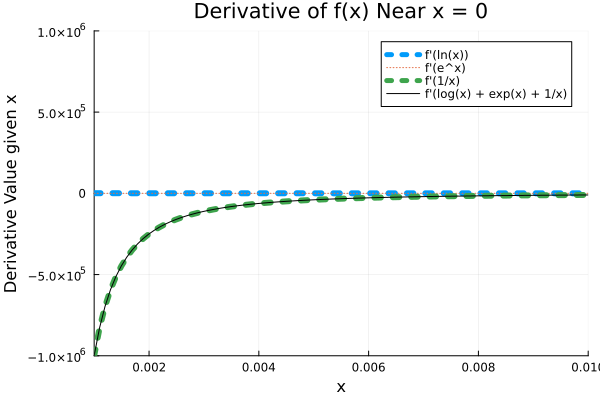

In [5]:
using ForwardDiff
using Plots

# Define the original function f(x)
function f(x)
    return log(x) + exp(x) + 1/x
end

# individual terms of the function
function term1(x)
    return log(x)       # ln(x)
end

function term2(x)
    return exp(x)       # e^x
end

function term3(x)
    return 1/x          # 1/x
end

# derivative of f(x) using Julia's auto diff solver
function f_prime(x)
    return ForwardDiff.derivative(f, x)
end

# the derivatives of the individual terms, so we can compare later
function term1_prime(x)
    return ForwardDiff.derivative(term1, x)   # Derivative of ln(x)
end

function term2_prime(x)
    return ForwardDiff.derivative(term2, x)   # Derivative of e^x
end

function term3_prime(x)
    return ForwardDiff.derivative(term3, x)   # Derivative of 1/x
end

# generate x values close to zero
x_values = range(0.001, 0.1, length=1000)

# compute it all!
f_prime_values = f_prime.(x_values)
term1_values = term1_prime.(x_values)
term2_values = term2_prime.(x_values)
term3_values = term3_prime.(x_values)

# graph them all!
plot(x_values, term1_values, label="f'(ln(x))", linestyle=:dot, linewidth=6, xlims=(0.001, 0.01), ylims=(-1e6, 1e6))
plot!(x_values, term2_values, label="f'(e^x)", linestyle=:dot)
plot!(x_values, term3_values, label="f'(1/x)", linestyle=:dot, linewidth=6)
plot!(x_values, f_prime_values, label="f'(log(x) + exp(x) + 1/x)", linestyle=:solid, linecolor=:black)
xlabel!("x")
ylabel!("Derivative Value given x")
title!("Derivative of f(x) Near x = 0")

Based on the graph above of the various derivatives of $f$'s terms, it's clear the the derivative of $1/x$ dominates the entire function's overall derivative. The overall derivative is the solid black line above, while the green dotted line represents the derivative of $1/x$.